Part 1: 

A) Write a colab/colabs where you will use advanced Keras deep learning constructs concepts



##User custom learning rate

Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load the TensorBoard notebook extension
%load_ext tensorboard

print("Keras Version : {}".format(keras.__version__))

Keras Version : 2.8.0


Prepare Dataset
Load dataset.  
Dataset used is Fashion MNIST.   
Split dataset into test and train dataset

In [ ]:
(X_train, Y_train), (X_test, Y_test) = datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train,X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)
Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)

classes =  np.unique(Y_train)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

Model Defining.     
Sequential Model using Conv2D layers

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers


def create_model():
    return Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape=(28,28,1)),
                    layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),
                    layers.Flatten(),
                    layers.Dense(10, activation="softmax")
                    ])

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 10)                125450    
                                                                 
Total params: 130,394
Trainable params: 130,394
Non-trainable params: 0
_________________________________________________________________


Custom learning rate scheduler - create a function which takes the learning rate, epoch as input and returns new learning rate.    

Pass this function to learningRateScheduler callback from "keras.callbacks" and this function will change the learning rate in every epoch

In [ ]:
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import os
import datetime


def custome_lr_scheduler(epoch, current_lr):
    return current_lr / 3


In [ ]:

model = create_model()  ## Create Model
epochs = 5

lr_schedule = LearningRateScheduler(custome_lr_scheduler)
grad_descent = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=grad_descent, loss="categorical_crossentropy", metrics=["accuracy"])
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.fit(x=X_train, y=Y_train, batch_size=64, epochs=epochs, validation_data=(X_test,Y_test), callbacks=[lr_schedule])

Epoch 1/5
938/938 [==============================] - 91s 96ms/step - loss: 0.8026 - accuracy: 0.7652 - val_loss: 0.5319 - val_accuracy: 0.8200 - lr: 3.3333e-04
Epoch 2/5
938/938 [==============================] - 90s 96ms/step - loss: 0.4684 - accuracy: 0.8388 - val_loss: 0.4905 - val_accuracy: 0.8336 - lr: 1.1111e-04
Epoch 3/5
938/938 [==============================] - 90s 96ms/step - loss: 0.4451 - accuracy: 0.8462 - val_loss: 0.4828 - val_accuracy: 0.8345 - lr: 3.7037e-05
Epoch 4/5
938/938 [==============================] - 90s 96ms/step - loss: 0.4385 - accuracy: 0.8483 - val_loss: 0.4801 - val_accuracy: 0.8355 - lr: 1.2346e-05
Epoch 5/5
938/938 [==============================] - 90s 96ms/step - loss: 0.4364 - accuracy: 0.8493 - val_loss: 0.4792 - val_accuracy: 0.8357 - lr: 4.1152e-06


In [ ]:
%tensorboard --logdir logs

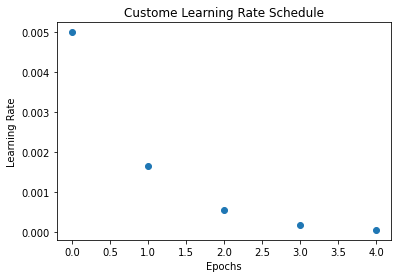

In [ ]:
import matplotlib.pyplot as plt

current_lr = 0.005
lrs = [current_lr]

for epoch in range(1,5):
    current_lr = custome_lr_scheduler(epoch, current_lr)
    lrs.append(current_lr)

plt.scatter(range(5), lrs);
plt.title("Custome Learning Rate Schedule");
plt.xlabel("Epochs")
plt.ylabel("Learning Rate");

##use custom dropout

Prepare Dataset
Load dataset.  
Dataset used is Fashion MNIST.   
Split dataset into test and train dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

Define Model for custom Dropout

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

Model summary

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

mc_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 mc_alpha_dropout_3 (MCAlpha  (None, 784)              0         
 Dropout)                                                        
                                                                 
 dense_7 (Dense)             (None, 300)               235500    
                                                                 
 mc_alpha_dropout_4 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_8 (Dense)             (None, 100)               30100     
                                                                 
 mc_alpha_dropout_5 (MCAlpha  (None, 100)             

Build Model

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, 
                                 momentum=0.9, nesterov=True)

mc_model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer=optimizer, metrics=["accuracy"])

mc_model.set_weights(model.get_weights())
n_epochs = 5

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = mc_model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6602 - accuracy: 0.7583 - val_loss: 0.5647 - val_accuracy: 0.7928
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5559 - accuracy: 0.7946 - val_loss: 0.5224 - val_accuracy: 0.8082
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5238 - accuracy: 0.8049 - val_loss: 0.5248 - val_accuracy: 0.8076
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5045 - accuracy: 0.8142 - val_loss: 0.4961 - val_accuracy: 0.8230
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4941 - accuracy: 0.8158 - val_loss: 0.4738 - val_accuracy: 0.8236


##Use custom normalization

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
from functools import partial

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

n_epochs = 5

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 12s 6ms/step - loss: 0.4732 - accuracy: 0.8325 - val_loss: 0.3669 - val_accuracy: 0.8640
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3518 - accuracy: 0.8724 - val_loss: 0.3768 - val_accuracy: 0.8700
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3272 - accuracy: 0.8800 - val_loss: 0.3577 - val_accuracy: 0.8714
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3179 - accuracy: 0.8824 - val_loss: 0.3319 - val_accuracy: 0.8794
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3097 - accuracy: 0.8852 - val_loss: 0.3295 - val_accuracy: 0.8842


##use tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

In [ ]:
def train_model():

  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4969 - accuracy: 0.8226 - val_loss: 0.4064 - val_accuracy: 0.8511
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3818 - accuracy: 0.8606 - val_loss: 0.4449 - val_accuracy: 0.8499
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3496 - accuracy: 0.8716 - val_loss: 0.3652 - val_accuracy: 0.8635
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3287 - accuracy: 0.8788 - val_loss: 0.4020 - val_accuracy: 0.8513
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3130 - accuracy: 0.8831 - val_loss: 0.3456 - val_accuracy: 0.8767


##use custom loss function 

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Prepare Dataset.     
load dataset - datase used is california dataset.   
split dataset into test and train dataset.   
Normalize dataset

In [ ]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Huber loass function

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

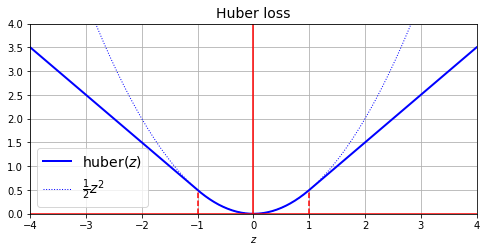

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)

plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")

plt.gca().axhline(y=0, color='r')
plt.gca().axvline(x=0, color='r')

plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

Model summary

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 30)                270       
                                                                 
 dense_17 (Dense)            (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.5986 - mae: 0.9499 - val_loss: 0.2577 - val_mae: 0.5465
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2095 - mae: 0.5013 - val_loss: 0.2122 - val_mae: 0.5008


save the above odel and apply custom loss function 

In [ ]:
model.save("model_custom_loss_function.h5")
model = keras.models.load_model("model_custom_loss_function.h5",
                                custom_objects={"huber_fn": huber_fn})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1837 - mae: 0.4658 - val_loss: 0.1735 - val_mae: 0.4490
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1821 - mae: 0.4629 - val_loss: 0.1702 - val_mae: 0.4491


In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("model_custom_loss_function_threshold.h5")

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2133 - mae: 0.4785 - val_loss: 0.2177 - val_mae: 0.4663
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2103 - mae: 0.4755 - val_loss: 0.2069 - val_mae: 0.4670


In [ ]:
model = keras.models.load_model("model_custom_loss_function_threshold.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.2068 - mae: 0.4708 - val_loss: 0.1889 - val_mae: 0.4479
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2037 - mae: 0.4667 - val_loss: 0.2111 - val_mae: 0.4649


In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.8854 - mae: 1.0036 - val_loss: 0.7657 - val_mae: 0.7615
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2650 - mae: 0.5224 - val_loss: 0.6709 - val_mae: 0.7131


In [ ]:
model.save("model_with_a_custom_loss_class.h5")

model = keras.models.load_model("model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2510 - mae: 0.5095 - val_loss: 0.5537 - val_mae: 0.6442
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2410 - mae: 0.5007 - val_loss: 0.4707 - val_mae: 0.6068


In [ ]:
model.loss.threshold

2.0

##Use custom activation function,initializer regularizer and kernel weight constraint

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5260 - mae: 0.4968 - val_loss: 1.0372 - val_mae: 0.4885
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5008 - mae: 0.4879 - val_loss: 0.8910 - val_mae: 0.4820
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4910 - mae: 0.4831 - val_loss: 0.7684 - val_mae: 0.4791


In [ ]:
model.save("model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 1.5901 - mae: 0.8871 - val_loss: 1.4671 - val_mae: 0.5719
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6168 - mae: 0.5327 - val_loss: 1.3017 - val_mae: 0.5177
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5340 - mae: 0.4998 - val_loss: 0.8996 - val_mae: 0.4890
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5089 - mae: 0.4909 - val_loss: 0.6983 - val_mae: 0.4803
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4977 - mae: 0.4852 - val_loss: 0.7704 - val_mae: 0.4810


In [ ]:
model.save("model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 3s 5ms/step - loss: 0.4920 - mae: 0.4840 - val_loss: 0.7208 - val_mae: 0.4725
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4875 - mae: 0.4815 - val_loss: 0.7401 - val_mae: 0.4797
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4843 - mae: 0.4802 - val_loss: 0.7693 - val_mae: 0.4712
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4817 - mae: 0.4799 - val_loss: 0.5728 - val_mae: 0.4656
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4780 - mae: 0.4771 - val_loss: 0.6951 - val_mae: 0.4728


##use custom metric

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6052 - huber_fn: 0.2733
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5113 - huber_fn: 0.2389
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4814 - huber_fn: 0.2306
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4646 - huber_fn: 0.2259


In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=5, sample_weight=sample_weight)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.1105 - huber_fn: 0.2243
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1087 - huber_fn: 0.2203
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1076 - huber_fn: 0.2179
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1060 - huber_fn: 0.2158
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1047 - huber_fn: 0.2128


In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11047787964344025, 0.11130256175433789)

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
m = HuberMetric(2.)
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))
m.result()

m.variables
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2595 - huber_metric: 0.2595
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2345 - huber_metric: 0.2345
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2281 - huber_metric: 0.2281
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2233 - huber_metric: 0.2233


In [ ]:
model.save("model_with_a_custom_metric.h5")
model = keras.models.load_model("model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=5)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.2195 - huber_metric: 0.2195
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2162 - huber_metric: 0.2162
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2137 - huber_metric: 0.2137
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2113 - huber_metric: 0.2113
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2090 - huber_metric: 0.2090


In [ ]:
model.metrics[-1].threshold

2.0

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}  

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=5, sample_weight=sample_weight)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 0.4455 - HuberMetric: 0.8978
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1305 - HuberMetric: 0.2631
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1176 - HuberMetric: 0.2370
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.1140 - HuberMetric: 0.2297
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.1116 - HuberMetric: 0.2250


In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()
model.save("model_with_a_custom_metric_v2.h5")

model = keras.models.load_model("model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2239 - HuberMetric: 0.2239
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.2184 - HuberMetric: 0.2184
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2144 - HuberMetric: 0.2144
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2109 - HuberMetric: 0.2109
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2082 - HuberMetric: 0.2082


In [ ]:
model.metrics[-1].threshold

2.0

##Use custom layers

Exponential layer to the regression model to predict positive values 

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])

model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3586


0.3586341142654419

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 1.7899 - val_loss: 0.7606
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6140 - val_loss: 0.5473
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4872 - val_loss: 0.5019
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4377 - val_loss: 0.6187
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4113 - val_loss: 0.4515


In [ ]:
model.evaluate(X_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3974


0.39740973711013794

In [ ]:
model.save("model_with_a_custom_layer.h5")
model = keras.models.load_model("model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [ ]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape


((11610, 4), (11610, 4))

In [ ]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [ ]:
model.compile(loss='mse', optimizer='nadam')
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=5,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/5
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 3s 5ms/step - loss: 2.1142 - val_loss: 1.3630
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.9684 - val_loss: 0.9773
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.9426 - val_loss: 0.9899
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.9267 - val_loss: 0.9619
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.9159 - val_loss: 0.9140


In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))


model.evaluate(X_test_scaled, y_test)


Epoch 1/5
363/363 [==============================] - 4s 5ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 1.0571 - val_loss: 4.4597
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 1.0382 - val_loss: 2.4851
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 1.0147 - val_loss: 1.2870
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.8249


0.8248994946479797

##Use custom model

In [ ]:
X_new_scaled = X_test_scaled

class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 4s 3ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 1.0578
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.8868
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5833
Epoch 5/5
162/162 [==============================] - 1s 2ms/step - loss: 0.6505


In [ ]:
model.save("custom_model.ckpt")
model = keras.models.load_model("custom_model.ckpt")
history = model.fit(X_train_scaled, y_train, epochs=5)

INFO:tensorflow:Assets written to: custom_model.ckpt/assets


INFO:tensorflow:Assets written to: custom_model.ckpt/assets


Epoch 1/5
363/363 [==============================] - 4s 4ms/step - loss: 0.8020
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5451
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4602
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.5316
Epoch 5/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4782


In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 1.1123
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4418
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4257
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3731
Epoch 5/5
162/162 [==============================] - 1s 2ms/step - loss: 0.5830


##Custom optimizer

In [ ]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 3.8128
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 1.4877
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.9162
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7587
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.7050


##Custom Training Loop

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [ ]:
from tqdm import trange
import collections

with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = collections.OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

Streaming output truncated to the last 5000 lines.
All epochs: 100%|██████████| 5/5 [04:59<00:00, 59.95s/it]
